In [1]:
# from mlguess.keras.models import EvidentialRegressorDNN
# import keras
# import numpy as np
# from mlguess.keras.callbacks import ReportEpoch
# from mlguess.keras.losses import evidential_cat_loss, evidential_reg_loss
# from keras.models import load_model
# import matplotlib.pyplot as plt

# import pandas as pd
# import xarray as xr
# import glob
# from os.path import join
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
# from sklearn.model_selection import train_test_split
# # from dataloader import create_xy_data

In [2]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import SGD, Adam, RMSprop
# from keras.regularizers import l2
# from keras.callbacks import EarlyStopping
# import keras.backend as K
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, LeakyReLU
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [3]:
# from SALib.analyze import fast as fast_analyze
# from SALib.sample import fast_sampler
# from SALib.sample import saltelli
# from SALib.analyze import sobol

# from SALib.sample.sobol import sample as sobol_sample
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
import sys
import os
project_dir = os.path.abspath("/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation")
#---------- Define paths for the specific subfolders
data_scripts_path = os.path.join(project_dir, "data_processing")
model_scripts_path = os.path.join(project_dir, "model")
#---------- Append the subfolder paths to sys.path
sys.path.append(data_scripts_path)
sys.path.append(model_scripts_path)

In [5]:
from packages import*

2025-04-09 19:10:57.829445: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 19:10:57.892076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 19:10:59.563702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from data_loader import x_input, y_input
# from global_mean import  global_mean
from spatial_ednn_model import evidential_regression_model
from regridder import regrid_to_lat_lon
from euclidean_distance import EucDistance
from fast_model import fast_model

## Load Data

In [7]:
#---------- Compute CLM PPE season
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"
djf_seas_tr, mam_seas_tr, jja_seas_tr, son_seas_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)
djf_seas_va, mam_seas_va, jja_seas_va, son_seas_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)

In [8]:
conus_gridcells = list(range(50, 150))
djf_conus = djf_seas_tr.sel(gridcell=conus_gridcells)

In [9]:
djf_conus.TLAI[:,1:200]

<xarray.DataArray 'TLAI' (gridcell: 100, sample: 199)>
dask.array<getitem, shape=(100, 199), dtype=float32, chunksize=(100, 199), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * time     (sample) object 1901-02-01 00:00:00 ... 1967-02-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

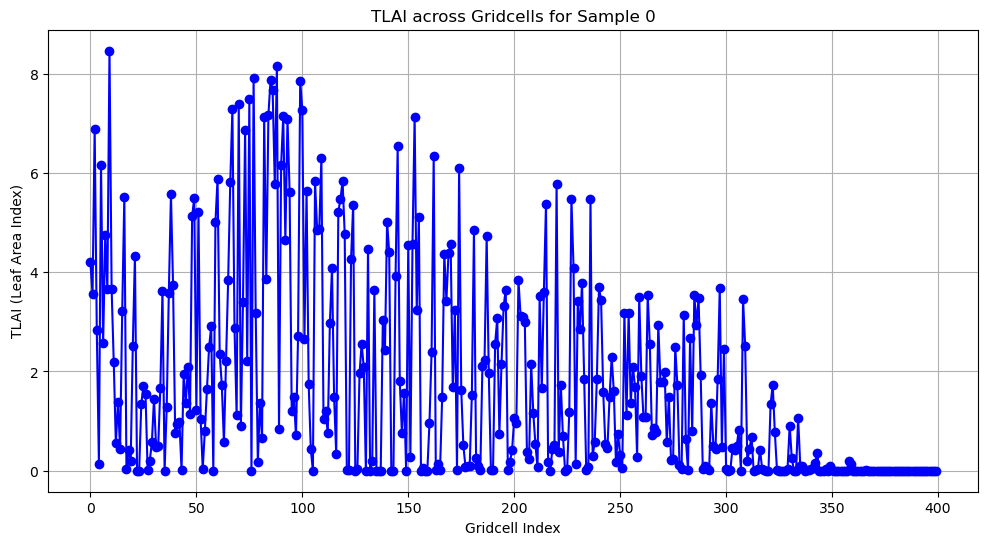

In [10]:
sample_index = 0
tlai_data = djf_seas_tr['TLAI'].isel(sample=sample_index)

# Plot TLAI values across grid cells
plt.figure(figsize=(12, 6))
plt.plot(tlai_data.gridcell, tlai_data, marker='o', linestyle='-', color='b')
plt.xlabel("Gridcell Index")
plt.ylabel("TLAI (Leaf Area Index)")
plt.title(f"TLAI across Gridcells for Sample {sample_index}")
plt.grid(True)
plt.show()


In [11]:
djf_seas_tr#.gridcell

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

In [12]:
djf_seas_tr.gridcell

<xarray.DataArray 'gridcell' (gridcell: 400)>
array([  0,   1,   2, ..., 397, 398, 399])
Dimensions without coordinates: gridcell

In [13]:
param_file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/lhc220926.txt"

#---------- Create x-train input
x_djf_tr, x_djf_tr_no_cyclic = x_input(djf_seas_tr, param_file_path)
x_mam_tr, x_mam_tr_no_cyclic = x_input(mam_seas_tr, param_file_path)
x_jja_tr, x_jja_tr_no_cyclic = x_input(jja_seas_tr, param_file_path)
x_son_tr, x_son_tr_no_cyclic = x_input(son_seas_tr, param_file_path)

#---------- Create x-train input
x_djf_va, x_djf_va_no_cyclic = x_input(djf_seas_va, param_file_path)
x_mam_va, x_mam_va_no_cyclic = x_input(mam_seas_va, param_file_path)
x_jja_va, x_jja_va_no_cyclic = x_input(jja_seas_va, param_file_path)
x_son_va, x_son_va_no_cyclic = x_input(son_seas_va, param_file_path)

In [14]:
djf_seas_tr

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

## Scale Data

#### Quantile Transformer 

In [15]:
#----------- Scaled x train and validation
scaler_x = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)

x_djf_va_scaled = scaler_x.transform(x_djf_va)
x_mam_va_scaled = scaler_x.transform(x_mam_va)
x_jja_va_scaled = scaler_x.transform(x_jja_va)
x_son_va_scaled = scaler_x.transform(x_son_va) 

In [16]:
#----------- Scaled x train and validation no cyclical encoding
scaler_x_no_cyclic = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)

x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [17]:
# #----------- Scaled x train and validation
# scaler_x = StandardScaler()
# x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
# x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
# x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
# x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)


# x_djf_va_scaled = scaler_x.transform(x_djf_va)
# x_mam_va_scaled = scaler_x.transform(x_mam_va)
# x_jja_va_scaled = scaler_x.transform(x_jja_va)
# x_son_va_scaled = scaler_x.transform(x_son_va) 

In [18]:
# #----------- Scaled x train and validation no cyclical encoding
# scaler_x_no_cyclic = StandardScaler()
# x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
# x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
# x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
# x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)


# x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
# x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
# x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
# x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [19]:
# EvidentialRegressorDNN??

## EDNN Model 

In [20]:
n_features = 35
n_output_tasks = 400

model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model"
model_path =  model_folder+"/sparse_djf_ednn_model.keras"

p_with_unc_djf, p_without_unc_djf, model_ednn_djf, history_djf = evidential_regression_model(
    x_djf_tr_scaled,
    djf_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9901
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1240
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2954
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3668
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4311
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5198
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5543
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5802
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6236
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6451
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_djf_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [21]:
model_path = model_folder+"/sparse_mam_ednn_model.keras"
p_with_unc_mam, p_without_unc_mam, model_ednn_mam, history_mam = evidential_regression_model(
    x_mam_tr_scaled,
    mam_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8354
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3065
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4504
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5274
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5903
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6754
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.7329
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.7728
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.8087
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.8486
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_mam_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [22]:
model_path = model_folder+"/sparse_jja_ednn_model.keras"
p_with_unc_jja, p_without_unc_jja, model_ednn_jja, history_jja = evidential_regression_model(
    x_jja_tr_scaled,
    jja_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2771
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2537
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1235
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0568
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0287
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.3706e-04
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0337
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0783
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1132
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1625
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_jja_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/save

In [23]:
model_path = model_folder+"/sparse_son_ednn_model.keras"
p_with_unc_son, p_without_unc_son, model_ednn_son, history_son = evidential_regression_model(
    x_son_tr_scaled,
    son_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.2386
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1485
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0335
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0244
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0559
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1093
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1688
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1962
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2390
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2687
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_son_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved

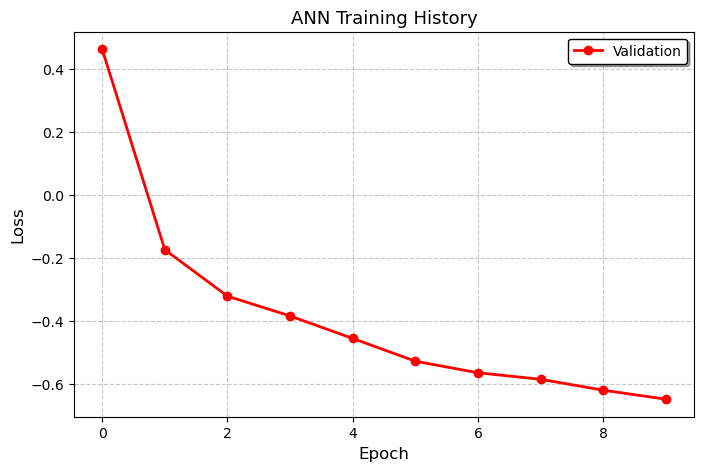

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(history_djf.epoch, history_djf.history['loss'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
# plt.plot(history_djf.epoch, history_djf.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

In [25]:
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [26]:
#----------- Pred LAI
pred_djf_lai = sparse_pred_ednn_djf[:,:400]
pred_mam_lai = sparse_pred_ednn_mam[:,:400]
pred_jja_lai = sparse_pred_ednn_jja[:,:400]
pred_son_lai = sparse_pred_ednn_son[:,:400]

#---------- Aleatoric 
pred_djf_alea = sparse_pred_ednn_djf[:,400:800] 
pred_mam_alea = sparse_pred_ednn_mam[:,400:800] 
pred_jja_alea = sparse_pred_ednn_jja[:,400:800] 
pred_son_alea = sparse_pred_ednn_son[:,400:800] 

#---------- Epistemic 
pred_djf_epis = sparse_pred_ednn_djf[:,800:] 
pred_mam_epis = sparse_pred_ednn_mam[:,800:] 
pred_jja_epis = sparse_pred_ednn_jja[:,800:] 
pred_son_epis = sparse_pred_ednn_son[:,800:] 

In [27]:
pred_djf_lai

array([[ 8.5498142e+00,  8.1234989e+00,  1.0903868e+01, ...,
         9.2148501e-04, -6.8129657e-04, -1.1553466e-03],
       [ 6.6814566e+00,  6.2584772e+00,  8.9658728e+00, ...,
        -4.8775808e-04, -9.5309794e-04,  8.4323564e-04],
       [ 8.5498142e+00,  8.1234989e+00,  1.0903868e+01, ...,
         9.2148501e-04, -6.8129657e-04, -1.1553466e-03],
       ...,
       [ 6.7164240e+00,  6.2455997e+00,  9.1381159e+00, ...,
        -1.2674651e-03, -8.5571350e-04,  8.6073403e-04],
       [ 5.4886093e+00,  5.0680094e+00,  7.6916423e+00, ...,
        -1.5072459e-03, -6.8642001e-04,  1.5250255e-03],
       [ 6.7164240e+00,  6.2455997e+00,  9.1381159e+00, ...,
        -1.2674651e-03, -8.5571350e-04,  8.6073403e-04]], dtype=float32)

In [28]:
########### Sparse Prediction
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [29]:
#------------------- Select CONUS region
us_lat_bounds = (25.031414,50)#(24.031414,49.47644)
us_lon_bounds = (233.75,293.75)

In [30]:
#################### EDNN Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_lai = {
    'djf': pred_djf_lai,
    'mam': pred_mam_lai,
    'jja': pred_jja_lai,
    'son': pred_son_lai
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn = {}
pred_ednn = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn[season] = xr.DataArray(
        data=pred_lai[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'total projected leaf area index',
            'units': '$m^2/m^2$',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn[season] = regrid_to_lat_lon(sparse_pred_ednn[season]).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
    
lat = pred_ednn['djf'].lat
lon = pred_ednn['djf'].lon

In [31]:
djf_seas_va_clm = regrid_to_lat_lon(djf_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
mam_seas_va_clm = regrid_to_lat_lon(mam_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
jja_seas_va_clm = regrid_to_lat_lon(jja_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
son_seas_va_clm = regrid_to_lat_lon(son_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))

In [32]:
lat

<xarray.DataArray 'lat' (lat: 13)>
array([25.578947, 27.473684, 29.368422, 31.263159, 33.157894, 35.052631,
       36.947369, 38.842106, 40.736843, 42.63158 , 44.526318, 46.421051,
       48.315788])
Coordinates:
  * lat      (lat) float64 25.58 27.47 29.37 31.26 ... 42.63 44.53 46.42 48.32

In [33]:
sparse_pred_ednn_djf.shape

(22500, 1200)

In [34]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_alea = {
    'djf': pred_djf_alea,
    'mam': pred_mam_alea,
    'jja': pred_jja_alea,
    'son': pred_son_alea
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_alea = {}
pred_ednn_alea = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_alea[season] = xr.DataArray(
        data=pred_alea[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Aleatoric Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_alea[season] = regrid_to_lat_lon(sparse_pred_ednn_alea[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [35]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_epis = {
    'djf': pred_djf_epis,
    'mam': pred_mam_epis,
    'jja': pred_jja_epis,
    'son': pred_son_epis
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_epis = {}
pred_ednn_epis = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_epis[season] = xr.DataArray(
        data=pred_epis[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Epistemic Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_epis[season] = regrid_to_lat_lon(sparse_pred_ednn_epis[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [36]:
# =============================================================================
# 4. Euclidean Distance Function
# =============================================================================
#================EXP1
djf = EucDistance(djf_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['djf'][:, :].mean(dim="sample"))
mam = EucDistance(mam_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['mam'][:, :].mean(dim="sample"))
jja = EucDistance(jja_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['jja'][:, :].mean(dim="sample"))
son = EucDistance(son_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['son'][:, :].mean(dim="sample"))

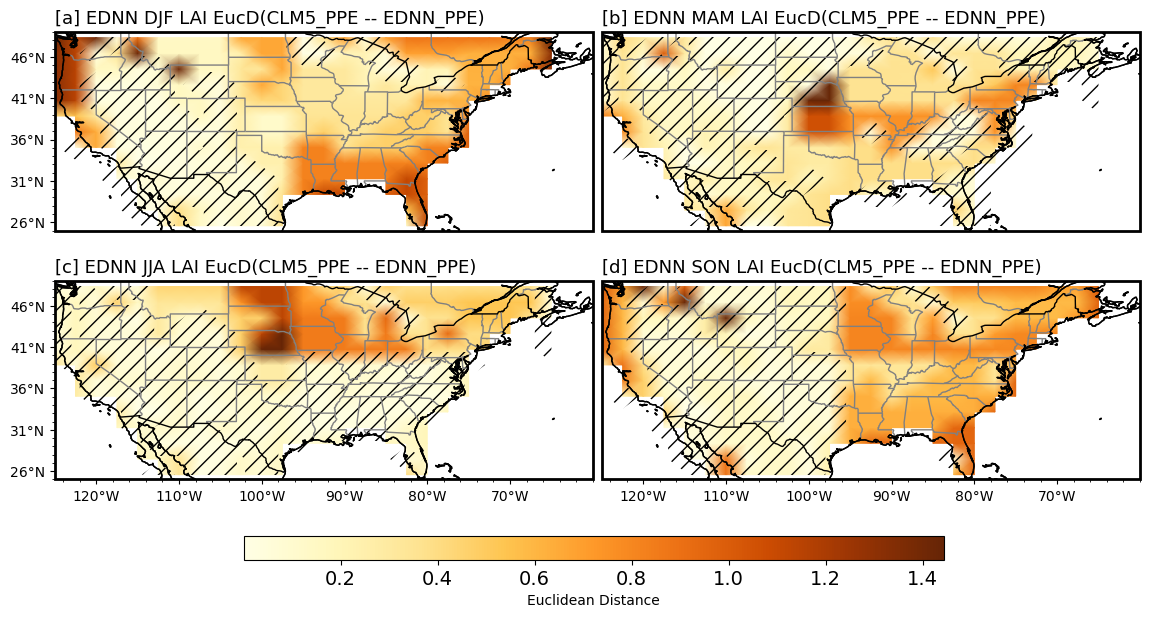

In [37]:
def make_plot_without_contours(
    data_nc: Any,
    ax: Axes,
    threshold: float,
    title: str,
    is_first_subplot: bool = False,
    is_last_row: bool = False
) -> QuadMesh:
    """
    Create a filled pcolormesh plot with a hatch overlay for regions below a threshold.

    Parameters
    ----------
    data_nc : Any
        Input data array (or similar object) containing at least 'lat' and 'lon' coordinates.
    ax : Axes
        The matplotlib GeoAxes on which to plot.
    threshold : float
        The threshold below which hatch patterns are applied.
    title : str
        The title for the subplot.
    is_first_subplot : bool, optional
        If True, sets the y-tick labels (default is False).
    is_last_row : bool, optional
        If True, sets the x-tick labels (default is False).

    Returns
    -------
    QuadMesh
        The QuadMesh object created by pcolormesh.
    """
    # --- Add a cyclic point to avoid a gap in the map
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']

    # --- Create a 2D meshgrid of longitudes and latitudes
    lons2d, lats2d = np.meshgrid(lons, lats)

    # --- Create a filled pcolormesh plot
    mesh = ax.pcolormesh(
        lons2d,
        lats2d,
        data,
        transform=ccrs.PlateCarree(),
        cmap='YlOrBr',
        shading='gouraud'
    )

    # --- Set the subplot title
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')

    # --- Create a hatch mask for areas below the threshold
    hatch_mask = np.ma.masked_less(data, threshold)
    ax.contourf(
        lons,
        lats,
        hatch_mask.mask,
        levels=[0.2, 3],
        colors='none',
        hatches=['//'],
        transform=ccrs.PlateCarree()
    )

    # --- Configure x-ticks for the bottom row of subplots
    if is_last_row:
        xticks = np.arange(-120, -60, 10)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())

    # --- Configure y-ticks for the first column of subplots
    if is_first_subplot:
        yticks = np.arange(26, 50, 5)
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

    # --- Add state and country boundaries
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')

    # --- Enable minor ticks and add coastlines
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)

    return mesh

# --- Main plotting routine
if __name__ == '__main__':
    # Create a 2x2 figure with Cartopy PlateCarree projection
    fig, ax = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=[14,8],
        subplot_kw={'projection': ccrs.PlateCarree()},
        gridspec_kw={'wspace': 0.017, 'hspace': -0.2}
    )

    # Set a border around each subplot for visual clarity
    common_extent = [-125, -60, 25, 49]
    for axis in ax.flat:
        axis.set_extent(common_extent, crs=ccrs.PlateCarree())
        axis.spines['geo'].set_edgecolor('black')
        axis.spines['geo'].set_linewidth(2)

    # Define the threshold for hatching
    threshold = 0.2

    # Create spatial maps for different seasons (replace djf, mam, jja, son with your data)
    mesh14a = make_plot_without_contours(
        djf, ax[0, 0], threshold,
        '[a] EDNN DJF LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True
    )
    mesh14b = make_plot_without_contours(
        mam, ax[0, 1], threshold,
        '[b] EDNN MAM LAI EucD(CLM5_PPE -- EDNN_PPE)'
    )
    mesh14c = make_plot_without_contours(
        jja, ax[1, 0], threshold,
        '[c] EDNN JJA LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True,
        is_last_row=True
    )
    mesh14d = make_plot_without_contours(
        son, ax[1, 1], threshold,
        '[d] EDNN SON LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_last_row=True
    )

    # --- Adjust layout and add a horizontal colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9)
    cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.03])
    cbar = fig.colorbar(mesh14d, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

    # --- Save and display the figure
    plt.savefig("./Figures/euclidean_dist.pdf", dpi=600, bbox_inches='tight')
    plt.show()


In [38]:
def _make_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # Set titles
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    # Create an inset axes using `ax.inset_axes`
    inset_ax = ax.inset_axes([.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    # Plot the distribution on the inset axes
    # Flatten the data and remove NaNs
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    inset_ax.hist(
        data_flat, bins=30, color='g', edgecolor='black'
    )
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    # Remove spines for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh

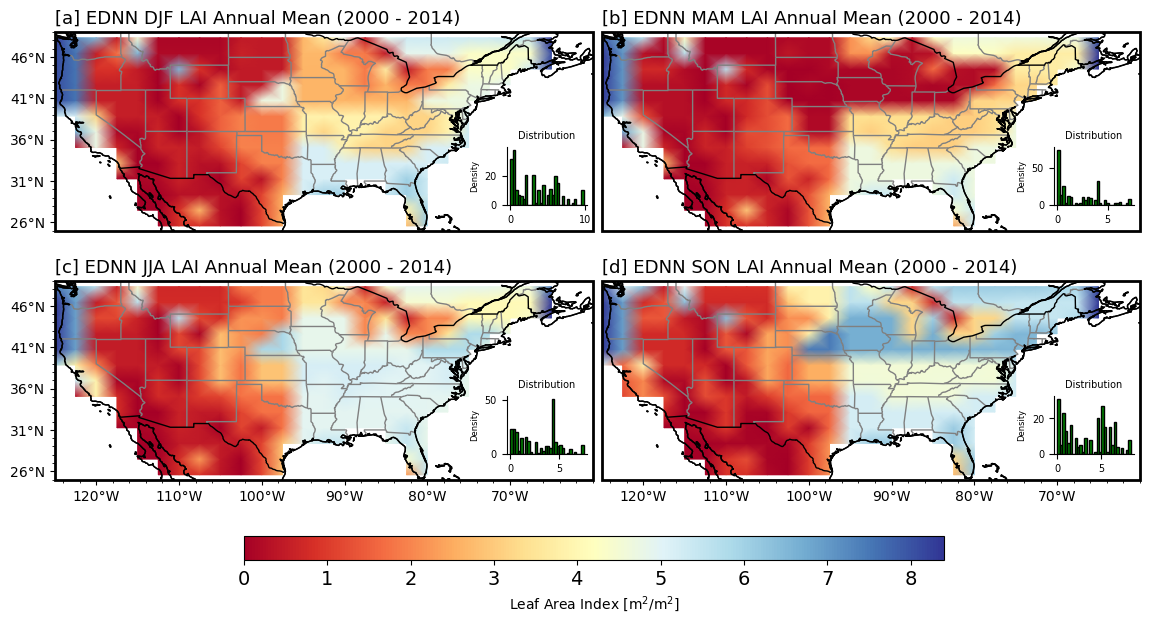

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.017, 'hspace': -0.2})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 

cs14a_ = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample") ,  ax[0,0], '[a] EDNN DJF LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample") ,  ax[0,1], '[b] EDNN MAM LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[1,0], '[c] EDNN JJA LAI Annual Mean (2000 - 2014)', is_first_subplot=True, is_last_row=True)
cs14d_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample") ,  ax[1,1], '[d] EDNN SON LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/conus_lai_.pdf", dpi = 600, bbox_inches='tight')

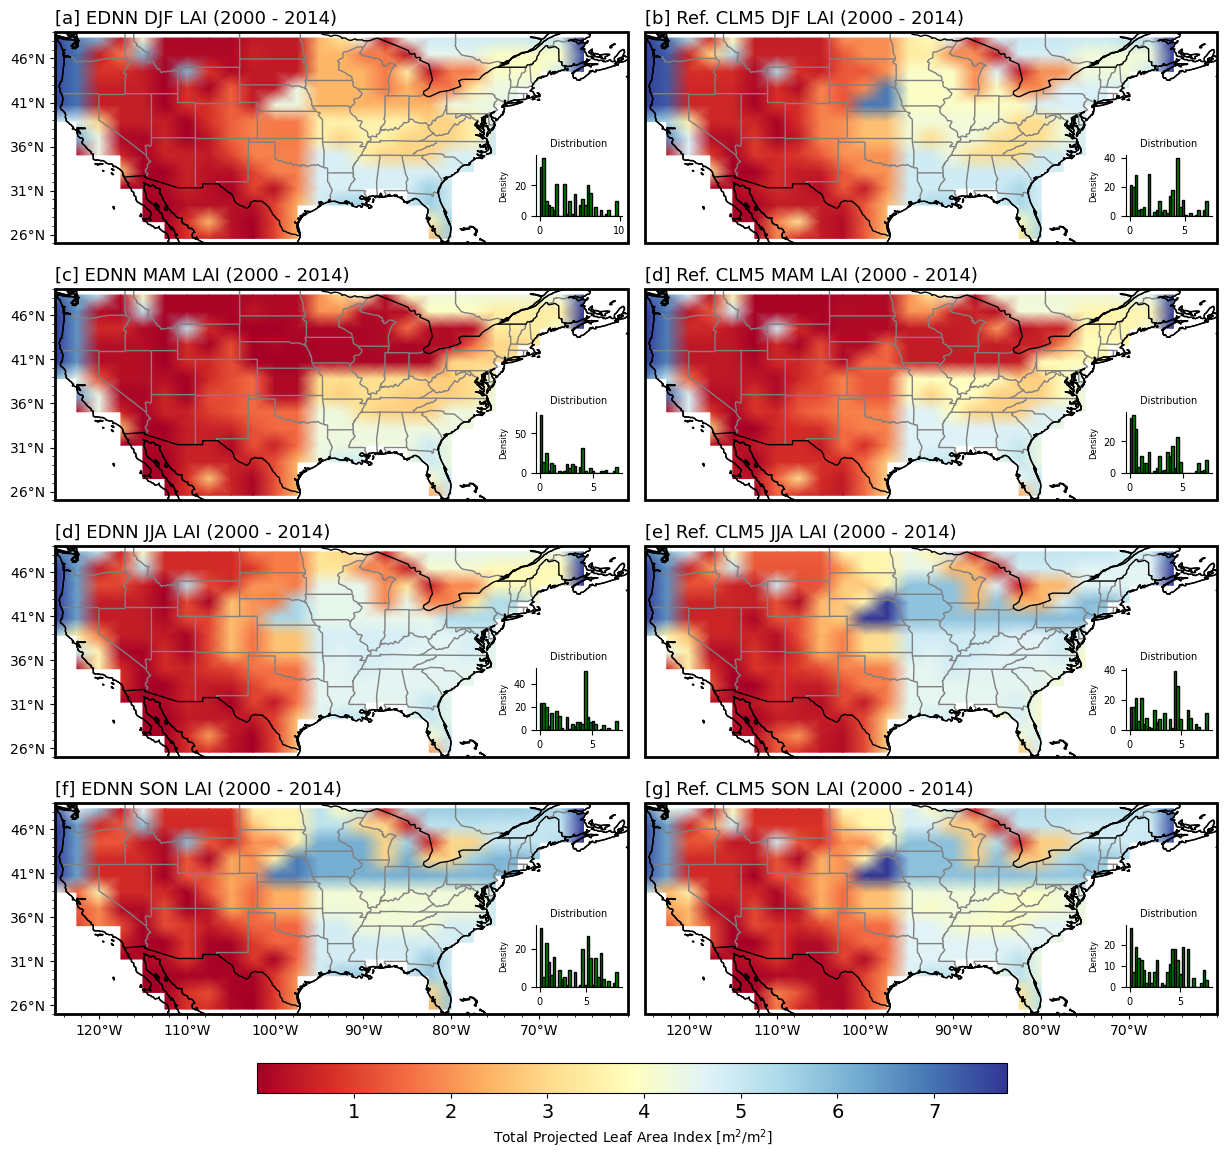

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.03,'hspace': -0.08})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
    
#============================================ Spatial Maps 
cs1e = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN DJF LAI (2000 - 2014) ', is_first_subplot=True)
cs11_ = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 DJF LAI (2000 - 2014)')
cs12_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[c] EDNN MAM LAI (2000 - 2014)', is_first_subplot=True)
cs13_ = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[d] Ref. CLM5 MAM LAI (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[2,0], '[d] EDNN JJA LAI (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[e] Ref. CLM5 JJA LAI (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[f] EDNN SON LAI (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[g] Ref. CLM5 SON LAI (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.02])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Total Projected Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/sparse_lai.pdf", dpi = 600, bbox_inches='tight')

In [57]:
def _make_plot_without_contours_(data_nc: xr.DataArray, ax: plt.Axes, title: str, 
                                   is_first_subplot: bool = False, is_last_row: bool = False):
    """
    Creates a filled pcolormesh plot on the given axes with a cyclic point added to the data.
    An inset histogram displaying the distribution of the data is also created.

    Parameters
    ----------
    data_nc : xr.DataArray
        The input data array to be plotted (with coordinates including 'lat', 'lon', etc.).
    ax : matplotlib.axes.Axes
        The axis on which to create the plot.
    title : str
        The title for the subplot.
    is_first_subplot : bool, optional
        If True, set up specific y-axis tick formatting (default is False).
    is_last_row : bool, optional
        If True, set up specific x-axis tick formatting (default is False).

    Returns
    -------
    mesh : matplotlib.collections.QuadMesh
        The QuadMesh object resulting from the pcolormesh plot.
    """
    # ---------- Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    # ---------- Create a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # ---------- Set subplot title: left-aligned title text
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    # ---------- Configure x-axis formatting if the subplot is in the last row
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    # ---------- Configure y-axis formatting if the subplot is the first in its column
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    
    # ---------- Add state boundaries and country borders
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    # ---------- Enable minor ticks, coastlines, and add coastline feature
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    # ---------- Create an inset axes and plot the histogram of the data distribution
    inset_ax = ax.inset_axes([.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    # Flatten the data, filter out NaN values
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    # Plot the histogram on the inset axes
    inset_ax.hist(data_flat, bins=30, color='g', edgecolor='black')
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    # Remove top and right spines for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh


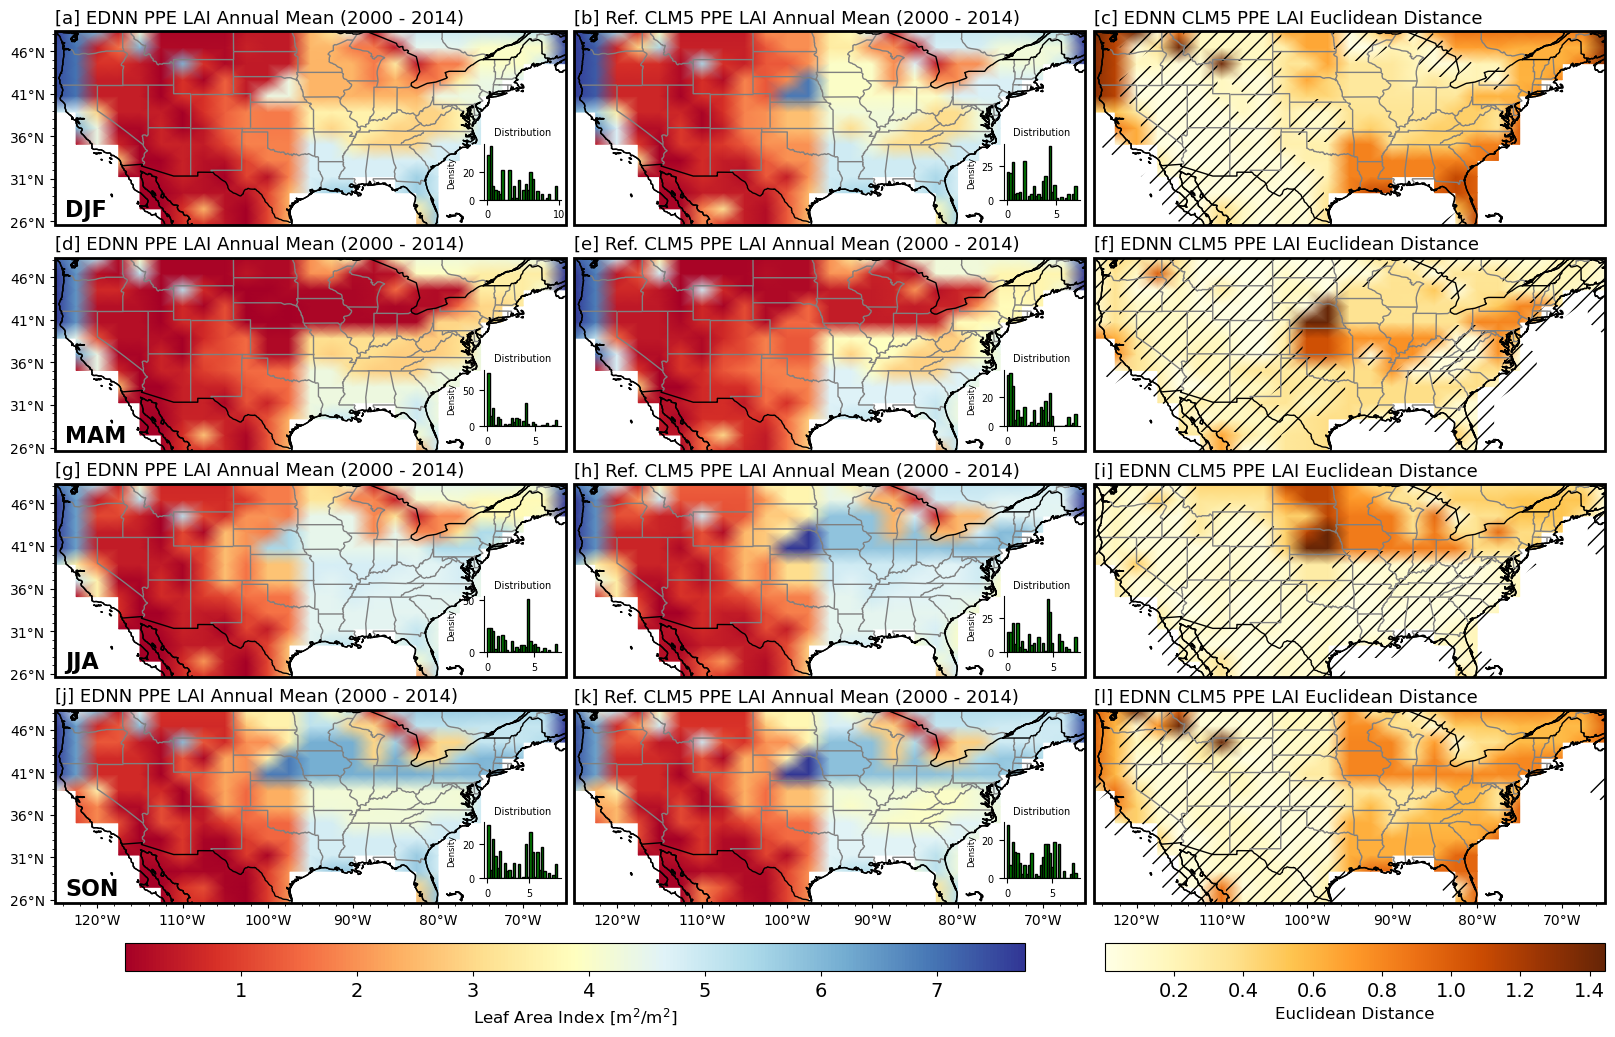

In [43]:
# Create a 4 (seasons) x 3 (variables) grid of subplots.
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[20, 14], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.017, 'hspace': -0.25})

# Set the border color and width for each subplot.
common_extent = [-125, -60, 25, 49]
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e   = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', is_first_subplot=True)
cs11_  = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')
cs12_  = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[d] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs13_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[e] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample"),   ax[2,0], '[g] EDNN PPE LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[h] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[j] EDNN PPE LAI Annual Mean (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[k] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(djf, ax[0,2], threshold,
                                       '[c] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14b_ = make_plot_without_contours(mam, ax[1,2], threshold,
                                       '[f] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14c_ = make_plot_without_contours(jja, ax[2,2], threshold,
                                       '[i] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False)
mesh14d_ = make_plot_without_contours(son, ax[3,2], threshold,
                                       '[l] EDNN CLM5 PPE LAI Euclidean Distance', is_first_subplot=False, is_last_row=True)

#------------------------------------------------------------------------
# Add season labels to the left-most subplot of each row.
# Adjust the coordinates (here, 0.02, 0.02 in axis coordinates) and fontsize as needed.
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i, 0].text(0.02, 0.02, season, transform=ax[i, 0].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')
#------------------------------------------------------------------------

# Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# Create a horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.16, 0.19, 0.45,  0.02])
cbar1 = fig.colorbar(cs14d_, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=12)

# Create a horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.19, 0.25,  0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=12)
plt.savefig("./Figures/combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()

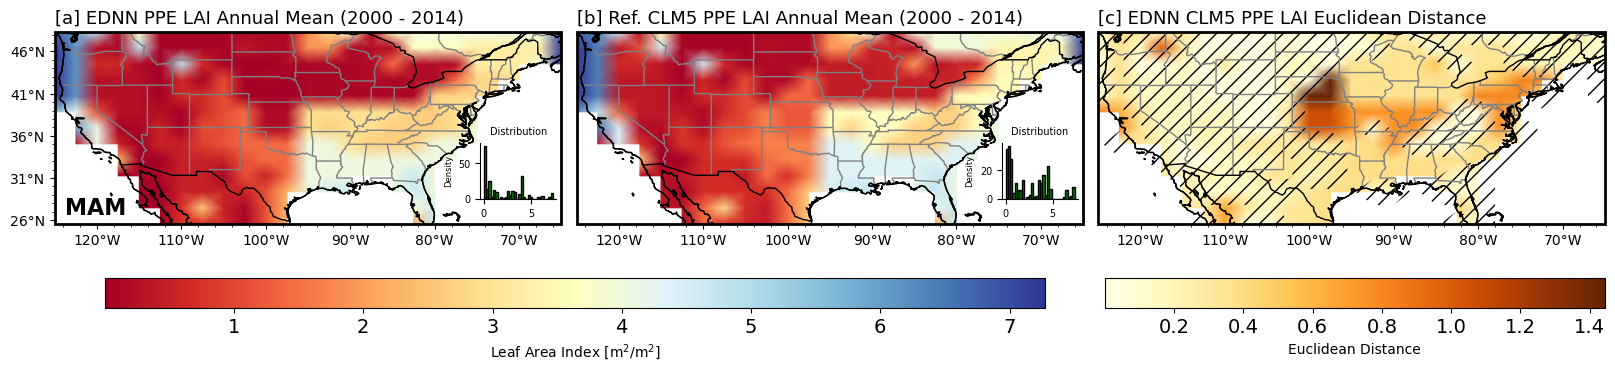

In [44]:
# Create a 4 (seasons) x 3 (variables) grid of subplots.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20, 15], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.03, 'hspace': -0.01})

# Set the border color and width for each subplot.
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e   = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),    ax[0], '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', is_last_row=True,is_first_subplot=True)
cs11_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1], '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(mam, ax[2], threshold,
                                       '[c] EDNN CLM5 PPE LAI Euclidean Distance', is_last_row=True, is_first_subplot=False)

#------------------------------------------------------------------------
# Add season labels to the left-most subplot of each row.
# Adjust the coordinates (here, 0.02, 0.02 in axis coordinates) and fontsize as needed.
seasons = ['MAM']#, 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i].text(0.02, 0.02, season, transform=ax[i].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')
#------------------------------------------------------------------------

# Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# Create a horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.15, 0.43, 0.47,  0.02])
cbar1 = fig.colorbar(cs1e, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
# Create a horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.43, 0.25,  0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

plt.savefig("./Figures/mam_combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [45]:
def uncert_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False, norm=None):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='coolwarm', shading='gouraud', norm=norm) #YlOrRd 
    
    # Set titles
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')
    
    #=================== Define the yticks for latitude

    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',
                                      scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.minorticks_on()  # This would enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    return mesh

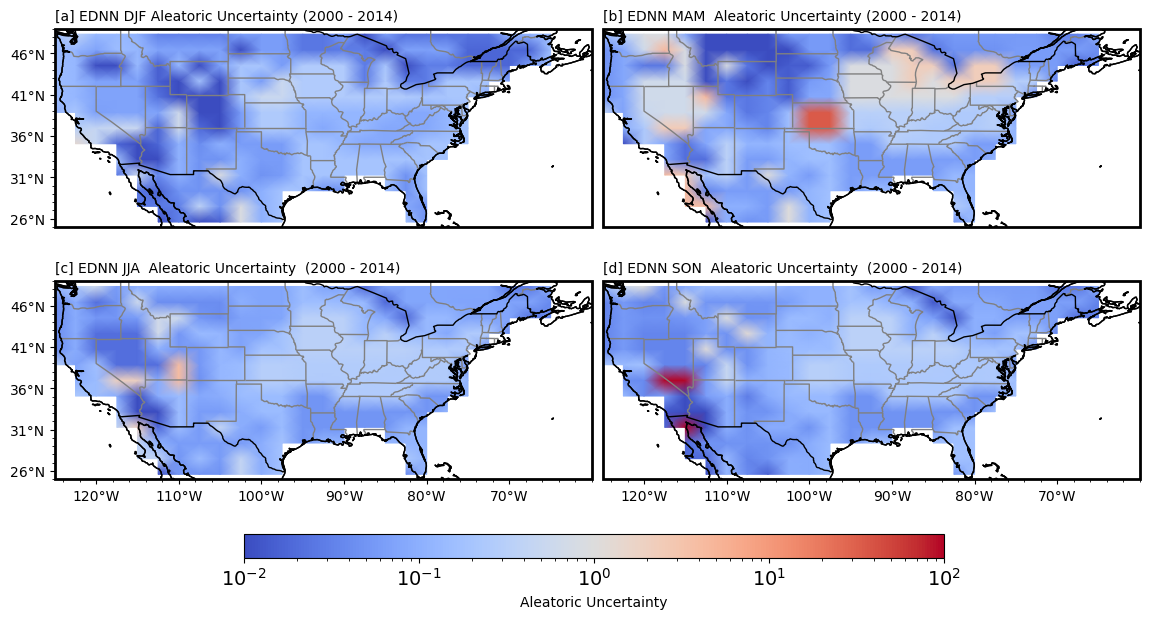

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 

mesh14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
mesh14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
mesh14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
mesh14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')
plt.show()


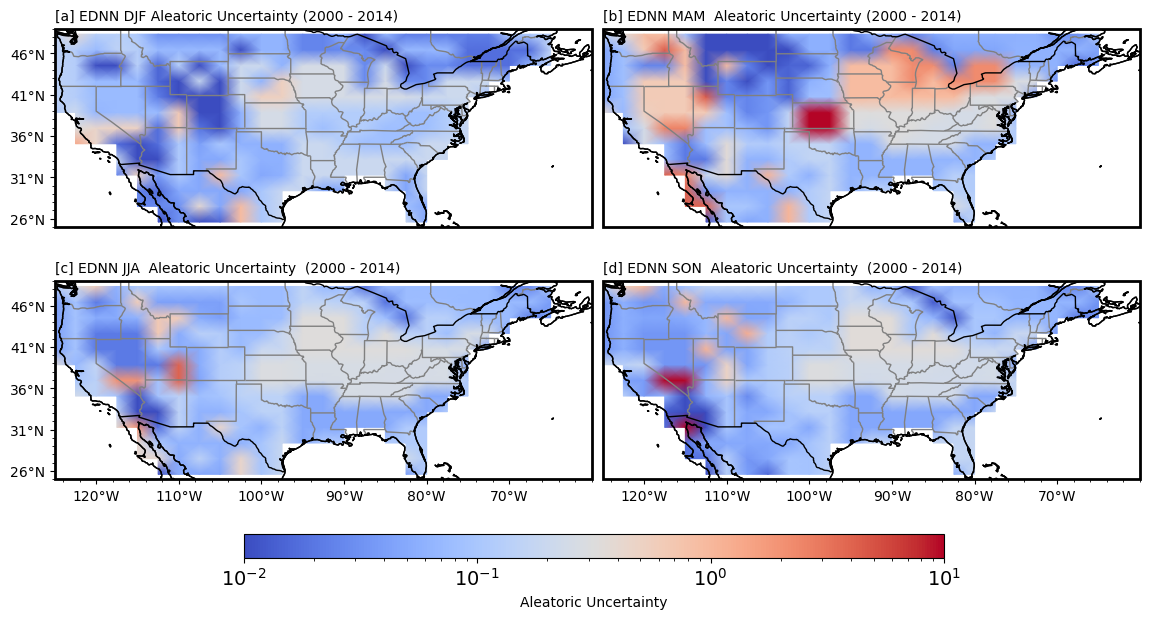

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e1)

#============================================ Spatial Maps 

cs14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')

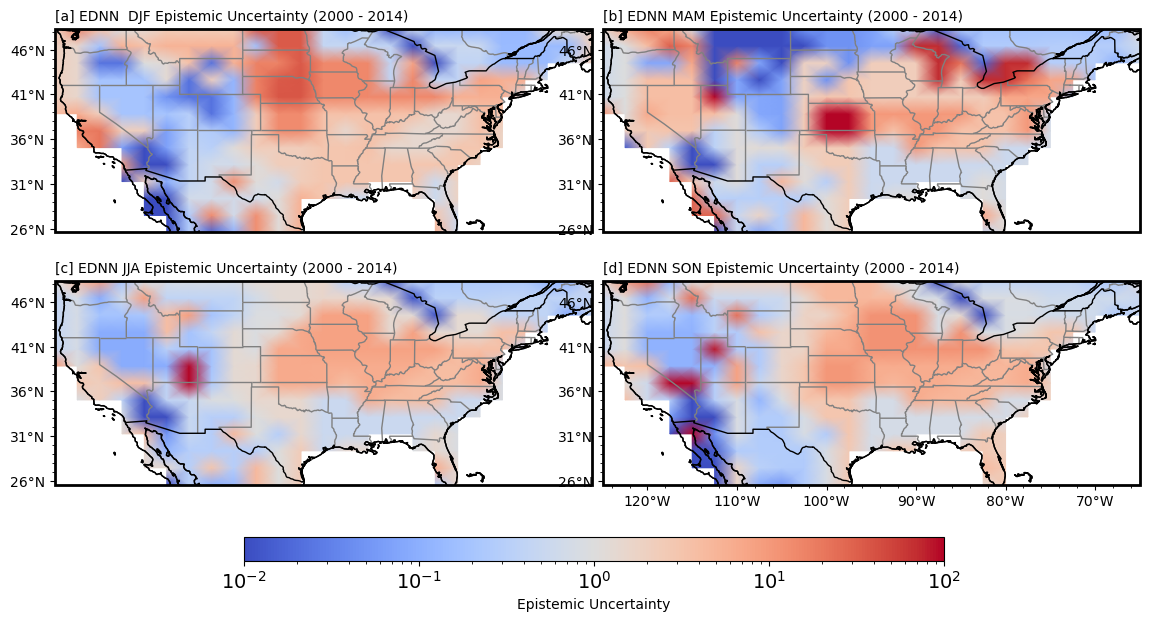

In [48]:
# Now apply this modified function to your plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.18})

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Use LogNorm for log scaling
log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 
cs14a_ = uncert_plot_without_contours_(pred_ednn_epis['djf'][:, :].mean(dim="sample"), ax[0,0], 
                              '[a] EDNN  DJF Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_epis['mam'][:, :].mean(dim="sample"), ax[0,1], 
                              '[b] EDNN MAM Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_epis['jja'][:, :].mean(dim="sample"), ax[1,0], 
                              '[c] EDNN JJA Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True,  norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_epis['son'][:, :].mean(dim="sample"), ax[1,1], 
                              '[d] EDNN SON Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, is_last_row=True,  norm=log_norm)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)

# Add colorbar label with units and mention the log scale
cbar.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=10)

# Save the figure
plt.savefig("./Figures/epistemic_Map.pdf", dpi=600, bbox_inches='tight')

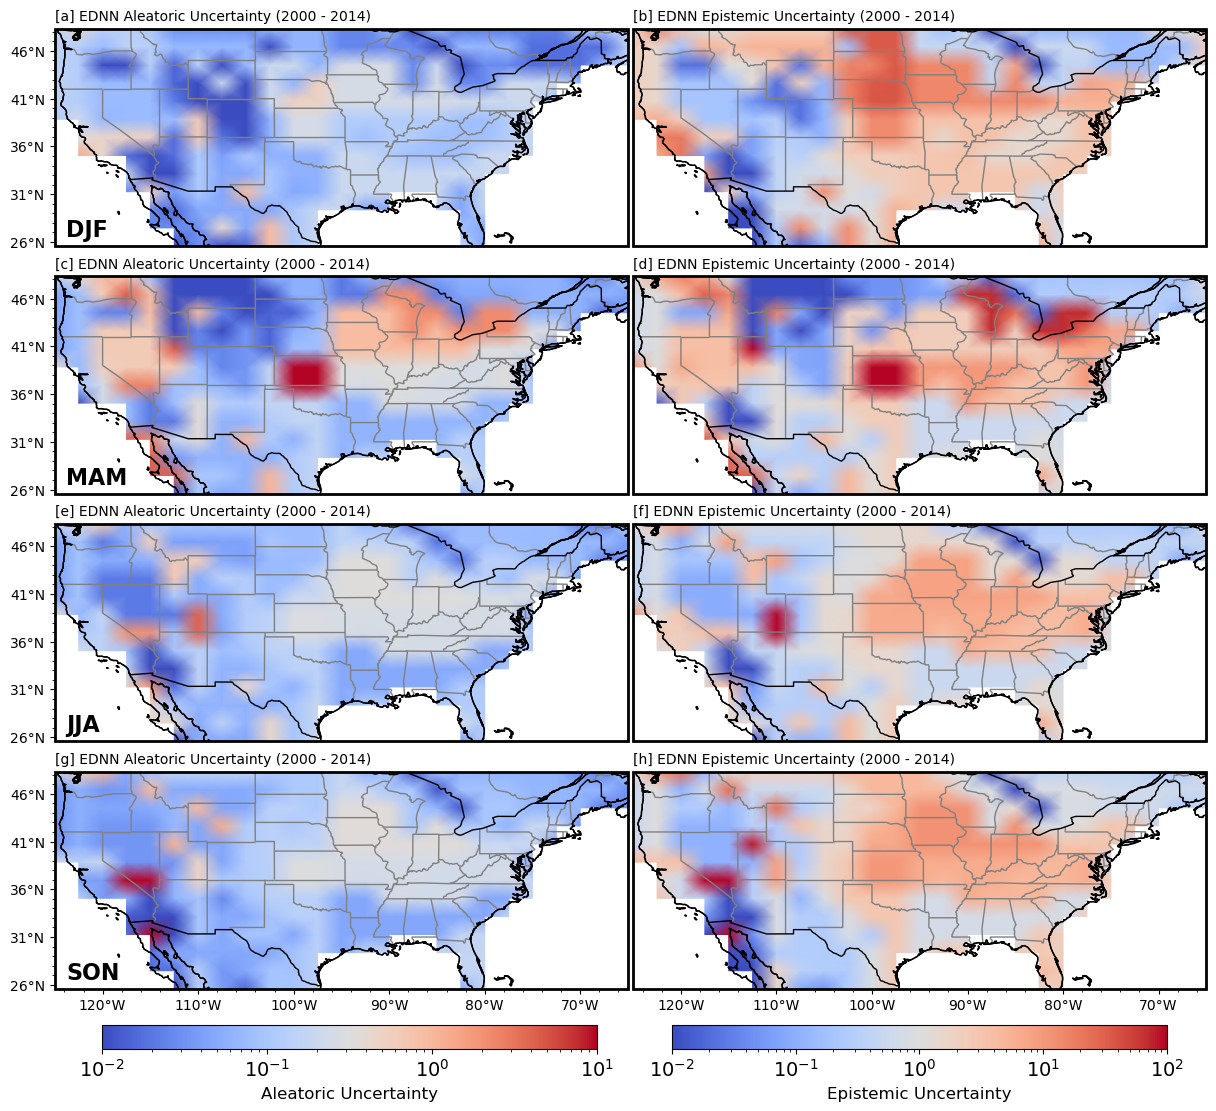

In [55]:
# =============================================================================
# Uncertainty Maps for EDNN LAI (FAST Analysis)
# =============================================================================

# ---------- Set global publication standards for font styling (if needed)
title_fontsize = 30         # Increase to enlarge subplot titles.
season_label_fontsize = 16  # Font size for the season label text.

# ---------- Create a 4 (seasons) x 2 (uncertainty types) grid of subplots with a PlateCarree projection
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': -0.01, 'hspace': 0.14})

# ---------- Set the Cartopy frame ("geo" spines) for each subplot
for axis in ax.flat:
    # If desired, set the geographical extent here (e.g., axis.set_extent(common_extent, crs=ccrs.PlateCarree()))
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# ---------- Define normalization for uncertainty data with logarithmic scaling
norm_alea = LogNorm(vmin=1e-2, vmax=1e1)   # Normalization for aleatoric uncertainty
norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)     # Normalization for epistemic uncertainty

# ---------- Define seasons and corresponding subplot titles for each column
seasons = ['djf', 'mam', 'jja', 'son']
titles_alea = [
    '[a] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[c] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[e] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[g] EDNN Aleatoric Uncertainty (2000 - 2014)'
]
titles_epi = [
    '[b] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[d] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[f] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[h] EDNN Epistemic Uncertainty (2000 - 2014)'
]

# ---------- Loop over each season and plot the corresponding uncertainty data
for i, season in enumerate(seasons):
    is_last = (i == len(seasons) - 1)  # Determine if it's the last row for further formatting

    # ---------- Left column: Plot aleatoric uncertainty map
    cs_alea = uncert_plot_without_contours_(
        pred_ednn_alea[season][:, :].mean(dim="sample"),
        ax=ax[i, 0],
        title=titles_alea[i],
        is_first_subplot=True,
        is_last_row=is_last,
        norm=norm_alea
    )
    
    # ---------- Right column: Plot epistemic uncertainty map
    cs_epi = uncert_plot_without_contours_(
        pred_ednn_epis[season][:, :].mean(dim="sample"),
        ax=ax[i, 1],
        title=titles_epi[i],
        is_first_subplot=False,
        is_last_row=is_last,
        norm=norm_epi
    )
    
    # ---------- Update title font sizes to the desired publication standard
    ax[i, 0].title.set_fontsize(title_fontsize)
    ax[i, 1].title.set_fontsize(title_fontsize)
    
    # ---------- Add a season label to the lower-left corner of the left subplot
    ax[i, 0].text(0.02, 0.02, season.upper(), transform=ax[i, 0].transAxes,
                  fontsize=season_label_fontsize, fontweight='bold',
                  va='bottom', ha='left', color='black')

# ---------- Adjust layout to provide space for horizontal colorbars at the bottom
plt.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.95)

# ---------- Create horizontal colorbars for the two uncertainty types
cbar_ax_alea = fig.add_axes([0.16, 0.1, 0.33, 0.02])  # Colorbar for aleatoric uncertainty
cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation="horizontal")
cbar_alea.ax.tick_params(labelsize=14)
cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)

cbar_ax_epi = fig.add_axes([0.54, 0.1, 0.33, 0.02])  # Colorbar for epistemic uncertainty
cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation="horizontal")
cbar_epi.ax.tick_params(labelsize=14)
cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# ---------- Save the combined figure as a high-resolution PDF
plt.savefig("./Figures/uncertainty_maps.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Sensitivity Analysis 

#### Season FAST

In [50]:
#------------ DJF
lai_djf_fast = fast_model(x_djf_tr, model_ednn_djf,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_djf = pd.DataFrame.from_dict(lai_djf_fast)
Si_djf.index = Si_djf.names
df_Si_djf = Si_djf.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.027194  0.052608  0.000152  0.004074
KCN                  0.000418  0.025339  0.000158  0.004066
a_fix                0.010008  0.031449  0.000151  0.004119
crit_dayl            0.000989  0.017813  0.000160  0.004163
d_max                0.000271  0.017899  0.000161  0.003991
fff                  0.000917  0.014708  0.000152  0.004064
froot_leaf           0.018453  0.036600  0.000165  0.004210
fstor2tran           0.003464  0.024181  0.000159  0.004341
grperc               0.006633  0.024198  0.000167  0.004272
jmaxb0               0.149321  0.193584  0.000152  0.004117
jmaxb1               0.115595  0.160004  0.000155  0.004120
kcha                 0.033698  0.060154  0.000156  0.004051
kmax                 0.001409  0.037702  0.000152  0.004011
krmax                0.000115  0.022888  0.000159  0.004116
leaf_long            0.053715  0.081506  0.000159  0.004

In [51]:
#------------ MAM
lai_mam_fast = fast_model(x_mam_tr, model_ednn_mam,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_mam = pd.DataFrame.from_dict(lai_mam_fast)
Si_mam.index = Si_mam.names
df_Si_mam = Si_mam.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.049580  0.086012  0.000163  0.004086
KCN                  0.001201  0.018513  0.000163  0.004160
a_fix                0.024620  0.047479  0.000160  0.004076
crit_dayl            0.002116  0.025533  0.000150  0.003971
d_max                0.000750  0.014074  0.000158  0.004157
fff                  0.001757  0.021704  0.000160  0.004067
froot_leaf           0.024856  0.053603  0.000161  0.004069
fstor2tran           0.002071  0.021172  0.000161  0.004293
grperc               0.002618  0.026524  0.000156  0.004016
jmaxb0               0.142016  0.203752  0.000156  0.004401
jmaxb1               0.064918  0.113034  0.000163  0.004098
kcha                 0.023917  0.063771  0.000162  0.004178
kmax                 0.000629  0.036889  0.000159  0.004344
krmax                0.000443  0.027361  0.000153  0.004081
leaf_long            0.040128  0.083258  0.000155  0.004

In [52]:
#------------ JJA
lai_jja_fast = fast_model(x_jja_tr, model_ednn_jja, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_jja = pd.DataFrame.from_dict(lai_jja_fast)
Si_jja.index = Si_jja.names
df_Si_jja = Si_jja.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.035797  0.091435  0.000157  0.003970
KCN                  0.001109  0.019052  0.000162  0.004224
a_fix                0.012561  0.053739  0.000152  0.004085
crit_dayl            0.000053  0.030293  0.000158  0.004073
d_max                0.000058  0.015299  0.000154  0.004213
fff                  0.000201  0.018732  0.000162  0.004102
froot_leaf           0.026470  0.061605  0.000161  0.004265
fstor2tran           0.002628  0.024812  0.000153  0.004067
grperc               0.009855  0.037512  0.000159  0.004175
jmaxb0               0.125712  0.209742  0.000153  0.004099
jmaxb1               0.093998  0.162286  0.000152  0.004174
kcha                 0.035614  0.066761  0.000159  0.004138
kmax                 0.004905  0.041031  0.000153  0.003977
krmax                0.000095  0.037025  0.000152  0.004264
leaf_long            0.021210  0.061703  0.000156  0.004

In [53]:
#------------ SON
lai_son_fast = fast_model(x_son_tr, model_ednn_son, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_son = pd.DataFrame.from_dict(lai_son_fast)
Si_son.index = Si_son.names
df_Si_son = Si_son.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.039240  0.070984  0.000151  0.004221
KCN                  0.002590  0.020104  0.000151  0.004096
a_fix                0.014720  0.033637  0.000164  0.004081
crit_dayl            0.000033  0.013120  0.000158  0.004049
d_max                0.000633  0.022213  0.000153  0.004038
fff                  0.000339  0.016307  0.000161  0.004014
froot_leaf           0.020037  0.045085  0.000156  0.004217
fstor2tran           0.002512  0.021828  0.000155  0.004060
grperc               0.002049  0.021038  0.000159  0.004102
jmaxb0               0.143837  0.195200  0.000151  0.004058
jmaxb1               0.113565  0.164531  0.000151  0.003965
kcha                 0.033042  0.061161  0.000157  0.004199
kmax                 0.005284  0.041674  0.000161  0.004040
krmax                0.000117  0.025821  0.000163  0.004088
leaf_long            0.034602  0.061139  0.000160  0.004

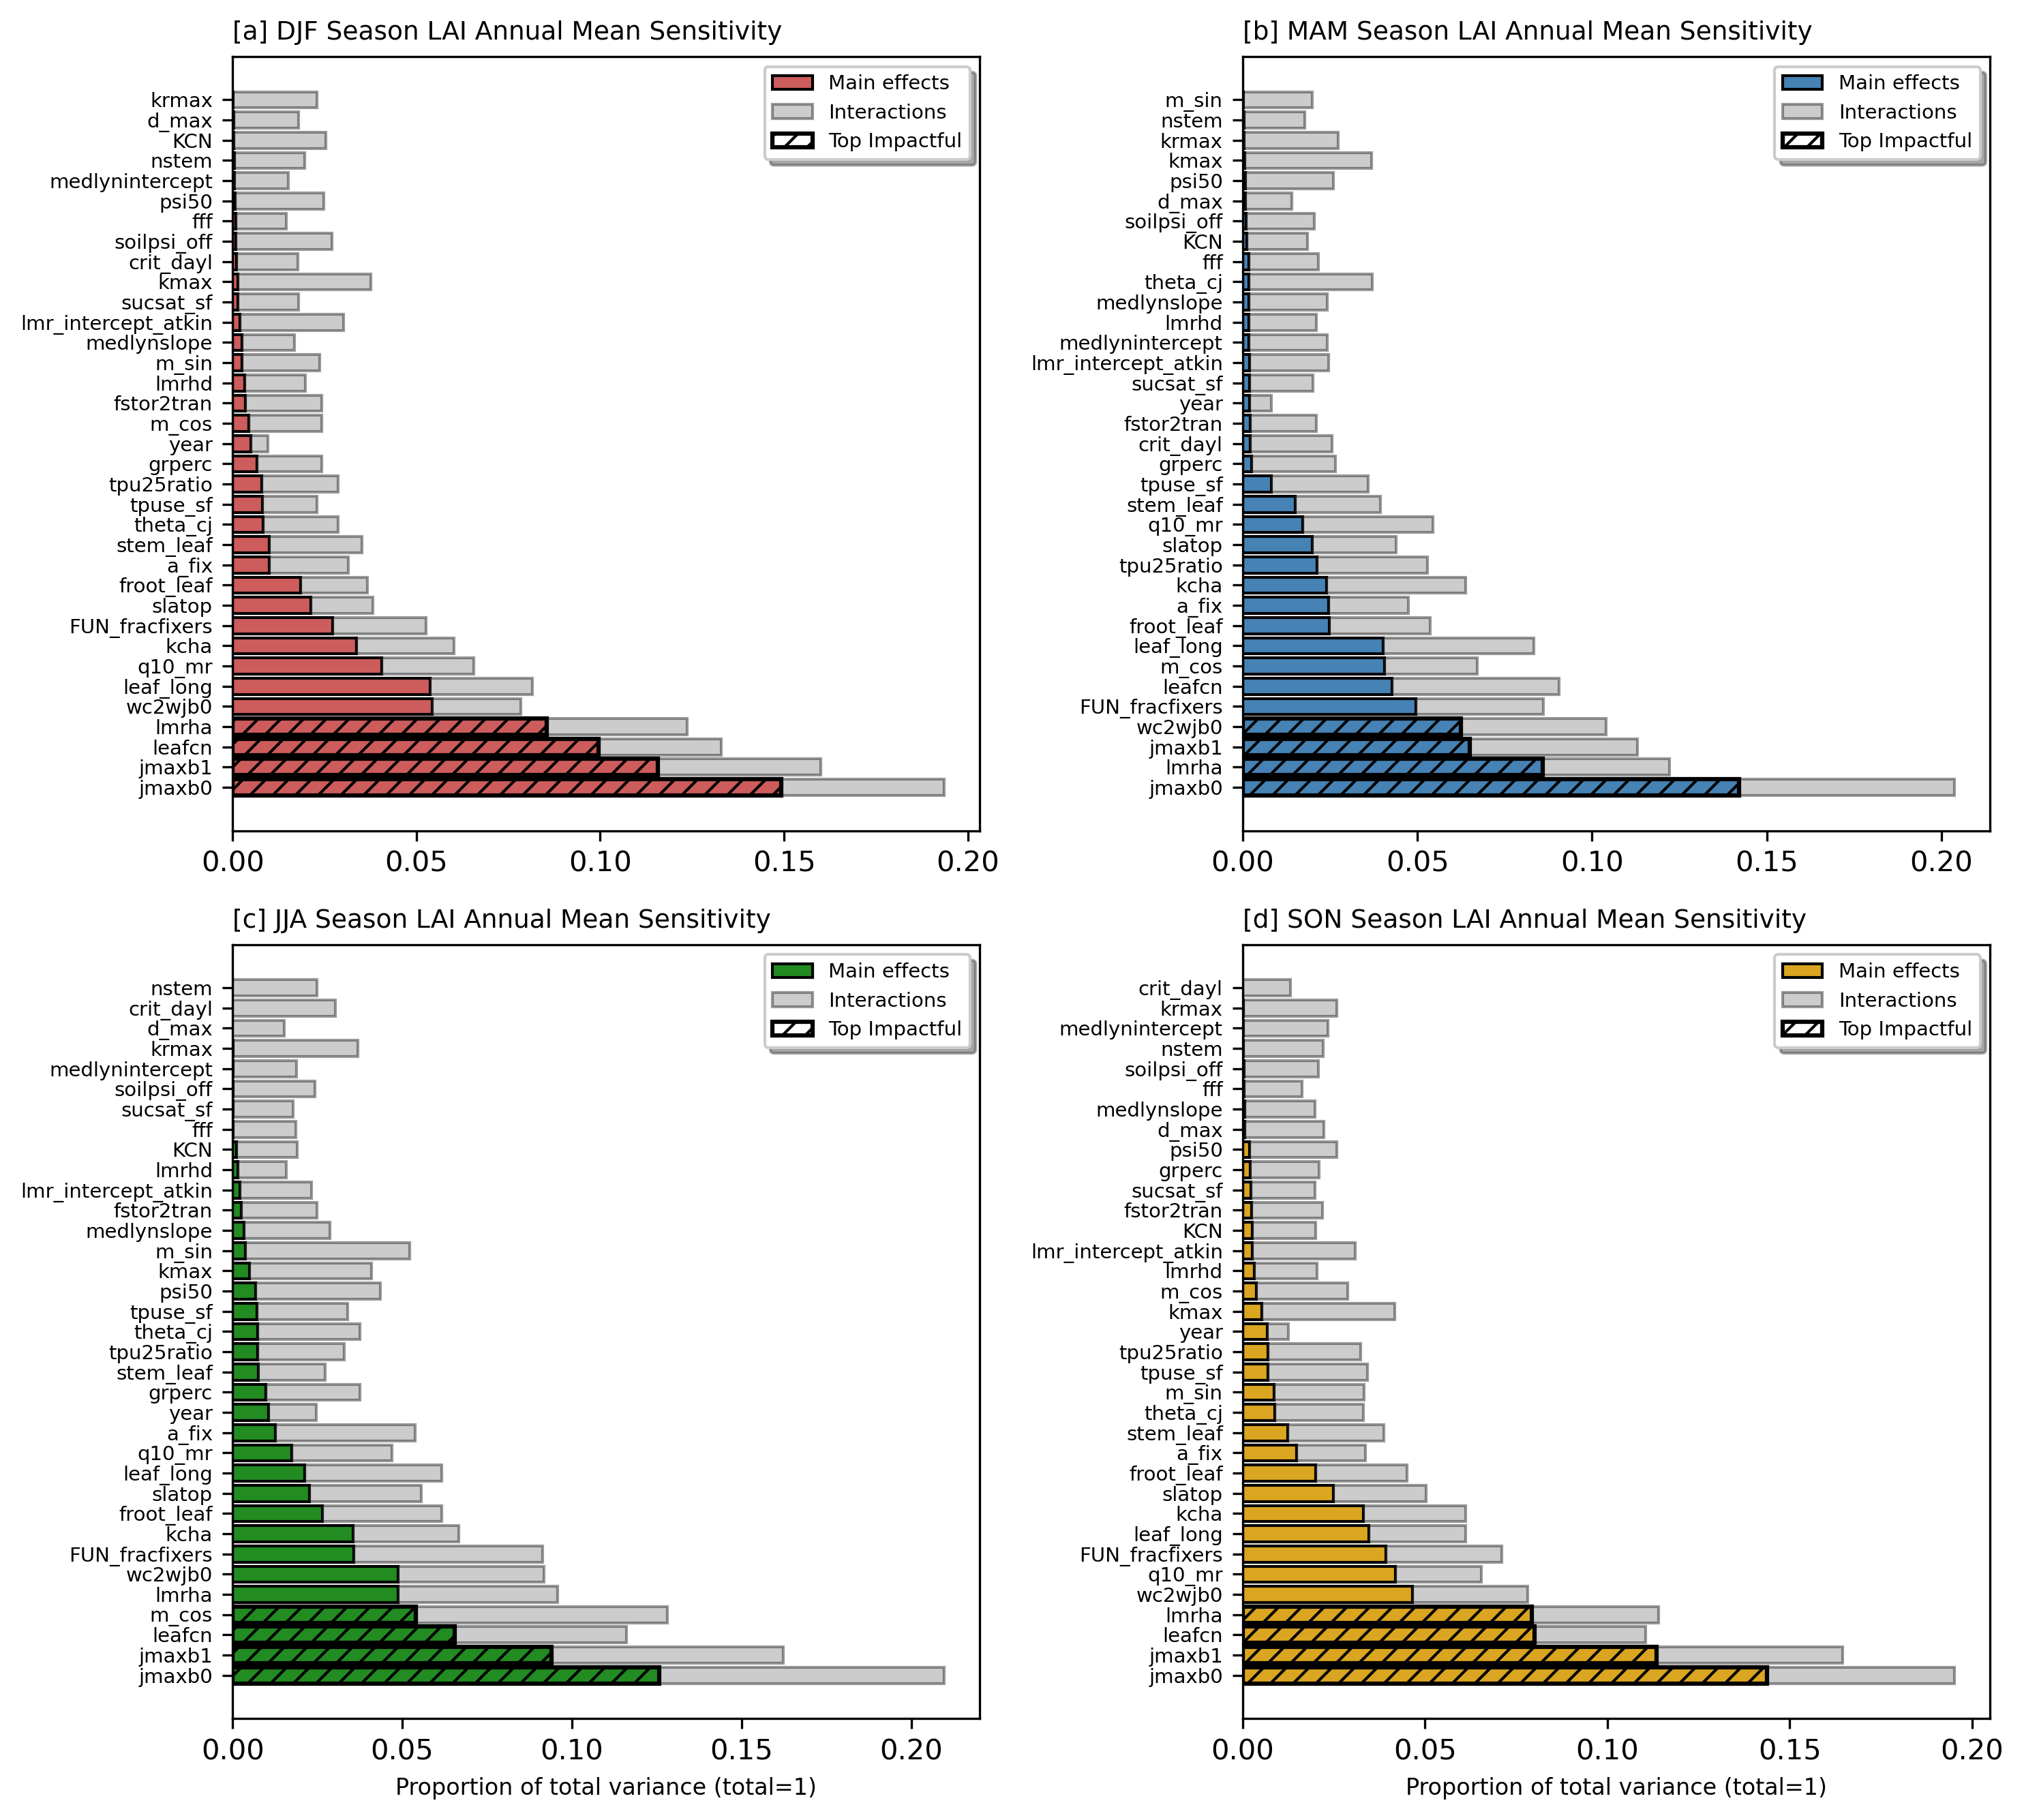

In [54]:
# =============================================================================
# FAST Sensitivity Analysis Plots for Seasonal LAI
# =============================================================================

# ---------- Define the helper function for FAST sensitivity plotting
def plot_sensitivity(ax, df: pd.DataFrame, title: str, bar_color: str, xlabel: bool = False) -> None:
    """
    Plot FAST sensitivity analysis as horizontal bar charts with main effects and interactions,
    and highlight the top 4 impactful parameters based on the main effect sensitivity (S1).

    Parameters:
        ax (matplotlib.axes.Axes): Axis object to plot the bar chart.
        df (pd.DataFrame): DataFrame containing the sensitivity data. Must have columns 'names', 'S1', and 'ST'.
        title (str): Title for the subplot; displayed on the left.
        bar_color (str): Color to use for the main effects bars.
        xlabel (bool, optional): If True, sets an x-axis label. Default is False.
    """
    # ---------- Identify the top 4 impactful parameters based on main effect sensitivity (S1)
    top_params = df.nlargest(4, 'S1')

    # ---------- Plot horizontal bars for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')

    # ---------- Plot horizontal bars for interaction effects (stacked on top of main effects)
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='grey', 
            label='Interactions', alpha=0.4, edgecolor='black')

    # ---------- Overlay hatched bars to highlight the top 4 parameters
    for i, name in enumerate(top_params.names):
        idx = df.index[df['names'] == name][0]
        # Overlay a transparent bar with hatching on the main effect value
        ax.barh(df.loc[idx, 'names'], df.loc[idx, 'S1'], color='none', 
                hatch='///', edgecolor='black', linewidth=1.5,
                label='Top Impactful' if i == 0 else None)

    # ---------- Customize y-axis tick labels
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    
    # ---------- Add legend (avoid duplicate labels)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=7)
    
    # ---------- Set x-axis label if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)', fontsize=8)
    
    # ---------- Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # ---------- Set subplot title: left-aligned title and add "FAST" label on the right
    ax.set_title(title, loc='left', fontsize=9)
    ax.text(0.98, 0.95, 'FAST', transform=ax.transAxes, ha='right', fontsize=9)

# ---------- Create a 2x2 subplot layout for the sensitivity plots
fig, axes = plt.subplots(2, 2, figsize=(10, 9), dpi=300)

# ---------- Plot sensitivity for each season
plot_sensitivity(axes[0, 0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivity', 'indianred', xlabel=False)
plot_sensitivity(axes[0, 1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivity', 'steelblue', xlabel=False)
plot_sensitivity(axes[1, 0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivity', 'forestgreen', xlabel=True)
plot_sensitivity(axes[1, 1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivity', 'goldenrod', xlabel=True)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/_fast_season_2x2_highlight.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()
